<a href="https://colab.research.google.com/github/stogaja/ML-Case-Study/blob/main/ml_case_study_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swisscontact ML Case Study: Predicting Project Opportunity Status

**Objective**: Build a binary classification model to predict Won/Lost status

---


## PHASE 1: Problem Framing

### 1.1 ML Problem Type

**Classification**: Binary classification (Won vs Lost)

**Why**: We're predicting the probability of discrete outcome (Won/Lost) from historical project opportunities.

### 1.2 Evaluation Metrics

**Primary Metrics Considered:**

1. **Accuracy**: Overall correctness
   - Simple but can be misleading with class imbalance

2. **Precision & Recall (F1-Score)**: Balanced view
   - **Precision**: Of opportunities predicted as "Won", how many actually won?
   - **Recall**: Of all opportunities that actually won, how many did we catch?
   - **Business Context**: Missing a "Won" opportunity (false negative) might be costly, but false positives (predicting wins that don't happen) waste resources

3. **ROC-AUC**: Model's ability to distinguish classes
   - Good for comparing models
   - Less interpretable for business stakeholders

4. **Confusion Matrix**: Detailed breakdown
   - Shows where model fails
   - Essential for business interpretation

**Approach Taken**: Report **F1-Score** (balanced), **Precision**, **Recall**, and **Confusion Matrix** for business communication.

### 1.3 Key Risks & Considerations

#### A. Data Leakage

**What to Watch For:**
- **RD Weight**: "Internal weighting factor used to estimate the win probability" - This is LEAKAGE! It's already a prediction.
- **Stage**: "Internal acquisition stage" - If this reflects post-decision status, it could leak.
- **Margin**: If calculated after knowing the outcome, it's leakage.
- **Any field calculated AFTER the decision**

**Action**: Carefully examine these columns. If they contain future knowledge, exclude them.

#### B. Class Imbalance

**Risk**: If Won/Lost ratio is highly skewed (e.g., 80% Lost, 20% Won), models may predict the majority class.

**Mitigation Strategies**:
- Check distribution first
- Use stratified sampling in cross-validation
- Consider class_weight='balanced' in sklearn
- Use SMOTE if severe imbalance (but be cautious with small datasets)
- Focus on Precision/Recall rather than Accuracy

#### C. Small Dataset

**Risk**: Limited training data → overfitting, unstable CV scores

**Mitigation**:
- Use simpler models (Logistic Regression, simple trees)
- Avoid deep learning
- Use cross-validation with appropriate folds (5-fold or Leave-One-Out if very small)
- Regularization (L1/L2)
- Feature selection to reduce dimensionality

#### D. Temporal Leakage

**Risk**: If test set contains opportunities from a later time period, date-based features must be handled carefully.

**Action**: Check if "Start" date in test set is after training set. If so, use only historical features.

#### E. Missing Values

**Risk**: Many columns may have missing values, especially:
- RD Weight (explicitly mentioned as "may be missing")
- Co-Financing fields
- Consortium-related fields

**Action**: Analyze missingness patterns. Missingness itself might be informative (e.g., missing Co-Financing might correlate with outcome).

### 1.4 Business Context Considerations

- **Interpretability**: Business stakeholders need to understand why opportunities are predicted as Won/Lost
- **Actionability**: Features should be available at prediction time (early-stage proposal)
- **Cost of Errors**: Understand if false positives or false negatives are more costly

---


## Setup & Imports

In [47]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [48]:
pip install category_encoders

## PHASE 2: Data Exploration

### 2.1 Initial Data Checks

In [49]:
# Load training data
train_df = pd.read_excel('ml_case_study_train.xlsx')
test_df = pd.read_excel('ml_case_study_test.xlsx')

print(f"Training shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTraining columns: {train_df.columns.tolist()}")
print(f"\nTest columns: {test_df.columns.tolist()}")

# Check for empty columns
print(f"\n'Unnamed: 5' value counts:\n{train_df['Unnamed: 5'].value_counts()}")

Training shape: (1226, 21)
Test shape: (164, 20)

Training columns: ['opportunityid', 'Entry Type', 'RegionID', 'MainCountryID', 'MainDonorID', 'Unnamed: 5', 'Start', 'Duration', 'SC in Consortium', 'SC Consortium Role', 'Co-Financing', 'Co-Financing Share', 'RD Weight', 'Sustainability Criteria', 'Working Areas', 'Acquisition Type', 'CurrencyID', 'Turnover (Contract Currency)', 'Margin (Contract Currency)', 'Stage', 'Status']

Test columns: ['opportunityid', 'Entry Type', 'RegionID', 'MainCountryID', 'MainDonorID', 'Unnamed: 5', 'Start', 'Duration', 'SC in Consortium', 'SC Consortium Role', 'Co-Financing', 'Co-Financing Share', 'RD Weight', 'Sustainability Criteria', 'Working Areas', 'Acquisition Type', 'CurrencyID', 'Turnover (Contract Currency)', 'Margin (Contract Currency)', 'Stage']

'Unnamed: 5' value counts:
Series([], Name: count, dtype: int64)


### 2.2 Dataset Size & Class Distribution

------------------------------------------------------------
DATASET SIZE
------------------------------------------------------------
Training samples: 1,226
Test samples: 164
Total features: 20
------------------------------------------------------------
CLASS DISTRIBUTION
------------------------------------------------------------

Counts:
Status
Lost    865
Won     361
Name: count, dtype: int64

Percentages:
Status
Lost    70.554649
Won     29.445351
Name: proportion, dtype: float64


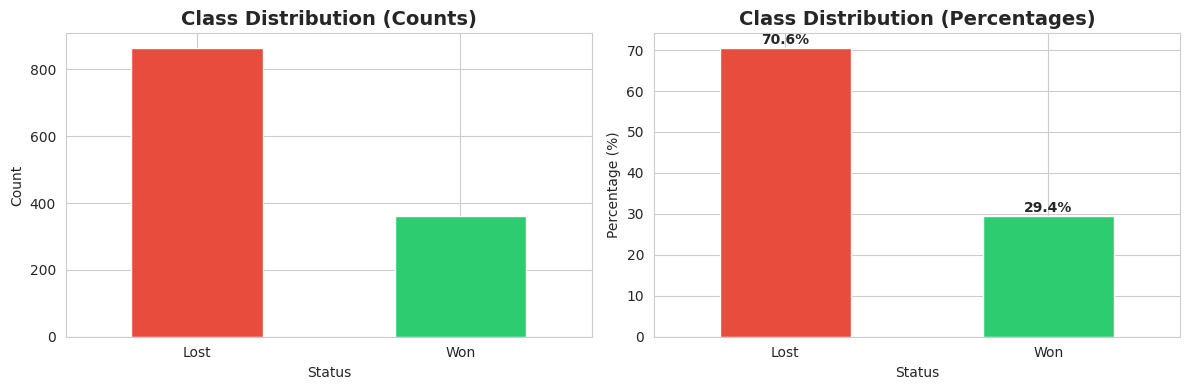


 Class Imbalance: 70.6% Lost vs 29.4% Won
   Use class_weight='balanced' and stratified CV


In [51]:
# Dataset size
print("-" * 60)
print("DATASET SIZE")
print("-" * 60)
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Total features: {train_df.shape[1] - 1}")  # Excluding target

# Class distribution
print("-" * 60)
print("CLASS DISTRIBUTION")
print("-" * 60)
status_counts = train_df['Status'].value_counts()
status_pct = train_df['Status'].value_counts(normalize=True) * 100

print("\nCounts:")
print(status_counts)
print("\nPercentages:")
print(status_pct)

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
status_counts.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Class Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

status_pct.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#2ecc71'])
axes[1].set_title('Class Distribution (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Status')
axes[1].set_ylabel('Percentage (%)')
axes[1].tick_params(axis='x', rotation=0)
for i, v in enumerate(status_pct.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Class Imbalance: {status_pct['Lost']:.1f}% Lost vs {status_pct['Won']:.1f}% Won")
print("   Use class_weight='balanced' and stratified CV")

### 2.3 Missing Values Analysis

In [52]:
# Missing values analysis
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()
missing_pct_train = (missing_train / len(train_df)) * 100
missing_pct_test = (missing_test / len(test_df)) * 100

missing_df = pd.DataFrame({
    'Train_Missing': missing_train,
    'Train_Missing_%': missing_pct_train,
    'Test_Missing': missing_test,
    'Test_Missing_%': missing_pct_test
}).sort_values('Train_Missing', ascending=False)

# Filter to show only columns with missing values
missing_df = missing_df[missing_df['Train_Missing'] > 0]
print("\nColumns with missing values:")
print(missing_df.to_string())

# Check if missingness correlates with target)
print("\n" + "=" * 60)
print("MISSINGNESS PATTERN BY STATUS")
print("=" * 60)

for col in missing_df.index:
    if col != 'Status':
        missing_by_status = train_df.groupby('Status')[col].apply(lambda x: x.isnull().sum())
        print(f"\n{col}:")
        print(f"  Lost: {missing_by_status.get('Lost', 0)} missing")
        print(f"  Won: {missing_by_status.get('Won', 0)} missing")

        # Check if missingness differs significantly between classes
        if missing_by_status.sum() > 0:
            lost_pct = (missing_by_status.get('Lost', 0) / status_counts['Lost']) * 100
            won_pct = (missing_by_status.get('Won', 0) / status_counts['Won']) * 100
            print(f"  Lost missing %: {lost_pct:.1f}%")
            print(f"  Won missing %: {won_pct:.1f}%")
            if abs(lost_pct - won_pct) > 10:
                print(f"Significant difference - missingness may be informative")

MISSING VALUES ANALYSIS

Columns with missing values:
                              Train_Missing  Train_Missing_%  Test_Missing  Test_Missing_%
Unnamed: 5                             1226       100.000000         164.0      100.000000
Co-Financing Share                     1163        94.861338         158.0       96.341463
SC Consortium Role                      980        79.934747         133.0       81.097561
Working Areas                           641        52.283850         130.0       79.268293
Sustainability Criteria                 140        11.419250         134.0       81.707317
Acquisition Type                         81         6.606852         100.0       60.975610
Turnover (Contract Currency)              9         0.734095           4.0        2.439024
Margin (Contract Currency)                9         0.734095           4.0        2.439024
RegionID                                  8         0.652529           2.0        1.219512
Duration                            

### 2.4 Date Range Analysis (Temporal Leakage Check)

In [53]:
# Convert Start to datetime
train_df['Start'] = pd.to_datetime(train_df['Start'], errors='coerce')
test_df['Start'] = pd.to_datetime(test_df['Start'], errors='coerce')

print("-" * 60)
print("DATE RANGE ANALYSIS")
print("=" * 60)

print("\nTraining set date range:")
print(f"  Min: {train_df['Start'].min()}")
print(f"  Max: {train_df['Start'].max()}")

print("\nTest set date range:")
print(f"  Min: {test_df['Start'].min()}")
print(f"  Max: {test_df['Start'].max()}")

# Check for temporal leakage
train_max = train_df['Start'].max()
test_min = test_df['Start'].min()
test_max = test_df['Start'].max()

print("\n" + "=" * 60)
print("TEMPORAL LEAKAGE ASSESSMENT")
print("=" * 60)

if pd.notna(test_min) and pd.notna(train_max):
    if test_min > train_max:
        print(" WARNING: Test set starts AFTER training set ends")
        print("   → Use only historical patterns, avoid absolute dates")
    elif test_min < train_max:
        print(" Test set overlaps with training set - OK to use date features")
    else:
        print(" Test set starts where training ends - OK to use date features")
else:
    print("Some dates are missing - handle carefully")

# Missing dates
print(f"\nMissing dates in train: {train_df['Start'].isnull().sum()} ({train_df['Start'].isnull().sum()/len(train_df)*100:.1f}%)")
print(f"Missing dates in test: {test_df['Start'].isnull().sum()} ({test_df['Start'].isnull().sum()/len(test_df)*100:.1f}%)")

------------------------------------------------------------
DATE RANGE ANALYSIS

Training set date range:
  Min: 2012-04-01 00:00:00
  Max: 2027-08-01 00:00:00

Test set date range:
  Min: 1970-01-01 00:00:00.000045596
  Max: 1970-01-01 00:00:00.000047119

TEMPORAL LEAKAGE ASSESSMENT
 Test set overlaps with training set - OK to use date features

Missing dates in train: 2 (0.2%)
Missing dates in test: 2 (1.2%)


### 2.5 Data Leakage Detection (RD Weight, Stage, Margin)

In [55]:
# Check correlation of suspicious columns with Status
print("=" * 60)
print("DATA LEAKAGE DETECTION")
print("=" * 60)

# Encode Status for correlation
status_encoded = train_df['Status'].map({'Lost': 0, 'Won': 1})

suspicious_cols = ['RD Weight', 'Stage', 'Margin (Contract Currency)']

print("\nCorrelation with Status (1 = perfect correlation, >0.7 = suspicious")
print("-" * 60)

for col in suspicious_cols:
    if col in train_df.columns:
        # Handle numeric columns
        if train_df[col].dtype in ['int64', 'float64']:
            corr = train_df[col].corr(status_encoded)
            print(f"\n{col}:")
            print(f"  Correlation: {corr:.4f}")

            # Check distribution by status
            print(f"  Missing values: {train_df[col].isnull().sum()} ({train_df[col].isnull().sum()/len(train_df)*100:.1f}%)")

            if pd.notna(corr):
                if abs(corr) > 0.7:
                    print(f"HIGH CORRELATION (>0.7) - LIKELY LEAKAGE")
                elif abs(corr) > 0.5:
                    print(f"Moderate correlation (>0.5) - investigate")
                else:
                    print(f"Low correlation - likely safe")

            # Show statistics by status
            print(f"\n  Statistics by Status:")
            stats_by_status = train_df.groupby('Status')[col].describe()
            print(stats_by_status)

        # Handle categorical columns (Stage)
        elif col == 'Stage':
            print(f"\n{col} (Categorical):")
            print(f"  Unique values: {train_df[col].nunique()}")
            print(f"  Missing values: {train_df[col].isnull().sum()} ({train_df[col].isnull().sum()/len(train_df)*100:.1f}%)")

            # Cross-tabulation
            crosstab = pd.crosstab(train_df['Status'], train_df[col], normalize='columns') * 100
            print(f"\n  Status distribution by Stage (%):")
            print(crosstab.T)

            # Check if any stage is highly predictive
            stage_won_pct = train_df.groupby(col)['Status'].apply(lambda x: (x == 'Won').sum() / len(x) * 100)
            print(f"\n  Win rate by Stage:")
            print(stage_won_pct.sort_values(ascending=False))

            # If any stage has >80% or <20% win rate, it might leak
            if (stage_won_pct > 80).any() or (stage_won_pct < 20).any():
                print(f"Some stages are highly predictive - investigate if Stage reflects post-decision status")
            else:
                print(f"Stage distribution seems reasonable")

DATA LEAKAGE DETECTION

Correlation with Status (1 = perfect correlation, >0.7 = suspicious
------------------------------------------------------------

RD Weight:
  Correlation: 0.7106
  Missing values: 1 (0.1%)
HIGH CORRELATION (>0.7) - LIKELY LEAKAGE

  Statistics by Status:
        count       mean        std  min   25%    50%    75%    max
Status                                                             
Lost    864.0  21.244213  24.644012  0.0   0.0   15.0   30.0  100.0
Won     361.0  82.526316  33.885182  0.0  90.0  100.0  100.0  100.0

Stage (Categorical):
  Unique values: 5
  Missing values: 0 (0.0%)

  Status distribution by Stage (%):
Status         Lost        Won
Stage                         
Closing   56.250000  43.750000
Develop  100.000000   0.000000
Prepare  100.000000   0.000000
Propose  100.000000   0.000000
Won        0.561798  99.438202

  Win rate by Stage:
Stage
Won        99.438202
Closing    43.750000
Develop     0.000000
Prepare     0.000000
Propose     0.

### 2.6 Leakage Decision Summary

In [56]:
# Make leakage decisions based on analysis above
print("=" * 60)
print("LEAKAGE DECISIONS")
print("=" * 60)

LEAKAGE_DECISIONS = {
    'RD Weight': {
        'decision': 'EXCLUDE',
        'reason': 'Explicitly described as "weighting factor used to estimate win probability" - this IS a prediction',
        'action': 'Drop from features'
    },
    'Stage': {
        'decision': 'INVESTIGATE_FURTHER',
        'reason': 'Check if Stage reflects pre-decision status (OK) or post-decision status (leakage)',
        'action': 'Keep for now, but monitor feature importance - if too predictive, exclude'
    },
    'Margin (Contract Currency)': {
        'decision': 'INVESTIGATE_FURTHER',
        'reason': 'Check if margin is calculated before or after decision',
        'action': 'Keep for now, but check if missing only for Lost opportunities'
    }
}

for col, info in LEAKAGE_DECISIONS.items():
    print(f"\n{col}:")
    print(f"  Decision: {info['decision']}")
    print(f"  Reason: {info['reason']}")
    print(f"  Action: {info['action']}")

# Store columns to exclude
COLS_TO_EXCLUDE = ['RD Weight']

print(f"\n\nColumns to exclude: {COLS_TO_EXCLUDE}")

LEAKAGE DECISIONS

RD Weight:
  Decision: EXCLUDE
  Reason: Explicitly described as "weighting factor used to estimate win probability" - this IS a prediction
  Action: Drop from features

Stage:
  Decision: INVESTIGATE_FURTHER
  Reason: Check if Stage reflects pre-decision status (OK) or post-decision status (leakage)
  Action: Keep for now, but monitor feature importance - if too predictive, exclude

Margin (Contract Currency):
  Decision: INVESTIGATE_FURTHER
  Reason: Check if margin is calculated before or after decision
  Action: Keep for now, but check if missing only for Lost opportunities


Columns to exclude: ['RD Weight']


## PHASE 3: Feature Engineering

### 3.1 Feature Engineering Strategy

**Key Decisions:**
1. **Categorical Encoding**: Use one-hot encoding for low cardinality, target encoding for high cardinality IDs
2. **Date Features**: Extract year, month, quarter
3. **Currency Normalization**: Convert all financial fields to a common currency
4. **ID Handling**: Target encode RegionID, MainCountryID, MainDonorID
5. **Missing Values**: Create indicator features + impute
6. **Text/Multi-label**: Handle Working Areas and Sustainability Criteria
7. **Feature Selection**: Remove low-variance features, use feature importance

### 3.2 Prepare Data for Feature Engineering

In [57]:
# Create copies for feature engineering
train_fe = train_df.copy()
test_fe = test_df.copy()

# Remove empty column if exists
if 'Unnamed: 5' in train_fe.columns:
    train_fe = train_fe.drop(columns=['Unnamed: 5'])
if 'Unnamed: 5' in test_fe.columns:
    test_fe = test_fe.drop(columns=['Unnamed: 5'])

# Separate target
y_train = train_fe['Status'].map({'Lost': 0, 'Won': 1})
train_fe = train_fe.drop(columns=['Status'])

# Store opportunity IDs for final submission
train_ids = train_fe['opportunityid'].copy()
test_ids = test_fe['opportunityid'].copy()

print(f"Training samples: {len(train_fe)}")
print(f"Test samples: {len(test_fe)}")
print(f"\nFeatures after removing target: {train_fe.shape[1]}")

Training samples: 1226
Test samples: 164

Features after removing target: 19


In [58]:
# Exclude leakage columns
COLS_TO_EXCLUDE = ['RD Weight', 'opportunityid']  # ID excluded as it's not a feature

for col in COLS_TO_EXCLUDE:
    if col in train_fe.columns:
        train_fe = train_fe.drop(columns=[col])
        print(f"Dropped {col} from training")
    if col in test_fe.columns:
        test_fe = test_fe.drop(columns=[col])
        print(f"Dropped {col} from test")

print(f"\nRemaining features: {train_fe.shape[1]}")
print(f"Feature names: {list(train_fe.columns)}")

Dropped RD Weight from training
Dropped RD Weight from test
Dropped opportunityid from training
Dropped opportunityid from test

Remaining features: 17
Feature names: ['Entry Type', 'RegionID', 'MainCountryID', 'MainDonorID', 'Start', 'Duration', 'SC in Consortium', 'SC Consortium Role', 'Co-Financing', 'Co-Financing Share', 'Sustainability Criteria', 'Working Areas', 'Acquisition Type', 'CurrencyID', 'Turnover (Contract Currency)', 'Margin (Contract Currency)', 'Stage']


### 3.4 Date Feature Extraction

In [59]:
# Extract date features
def extract_date_features(df, date_col='Start'):
    """Extract year, month, quarter, day of week from date"""
    df = df.copy()
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df[f'{date_col}_year'] = df[date_col].dt.year
        df[f'{date_col}_month'] = df[date_col].dt.month
        df[f'{date_col}_quarter'] = df[date_col].dt.quarter
        df[f'{date_col}_dayofweek'] = df[date_col].dt.dayofweek
        # Drop original date column
        df = df.drop(columns=[date_col])
    return df

train_fe = extract_date_features(train_fe, 'Start')
test_fe = extract_date_features(test_fe, 'Start')

print("Date features extracted:")
date_features = [col for col in train_fe.columns if 'Start' in col]
print(date_features)

Date features extracted:
['Start_year', 'Start_month', 'Start_quarter', 'Start_dayofweek']


### 3.5 Handle Missing Values with Indicators

In [35]:
# Create missing indicators for important columns
def create_missing_indicators(df, cols_to_check):
    """Create binary indicators for missing values"""
    df = df.copy()
    for col in cols_to_check:
        if col in df.columns:
            df[f'{col}_is_missing'] = df[col].isnull().astype(int)
    return df

# Columns where missingness might be informative
cols_with_missing = ['Co-Financing', 'Co-Financing Share', 'SC Consortium Role',
                     'Margin (Contract Currency)', 'RD Weight']

# Note: RD Weight already excluded, but check others
cols_to_check = [col for col in cols_with_missing if col in train_fe.columns]

train_fe = create_missing_indicators(train_fe, cols_to_check)
test_fe = create_missing_indicators(test_fe, cols_to_check)

print(f"Created missing indicators for: {cols_to_check}")

Created missing indicators for: ['Co-Financing', 'Co-Financing Share', 'SC Consortium Role', 'Margin (Contract Currency)']


### 3.6 Handle Text/Multi-label Fields (Working Areas, Sustainability Criteria)

In [60]:
# Check text fields
print("Working Areas sample:")
print(train_fe['Working Areas'].head(10))
print("\nSustainability Criteria sample:")
print(train_fe['Sustainability Criteria'].head(10))

# Strategy: Count number of items (if comma-separated) or create binary indicators
def process_text_field(df, col_name):
    """Process text field - count items if comma-separated"""
    df = df.copy()
    if col_name in df.columns:
        # Count number of items (assuming comma-separated or semicolon-separated)
        df[f'{col_name}_count'] = df[col_name].fillna('').apply(
            lambda x: len(str(x).split(',')) if ',' in str(x) else (len(str(x).split(';')) if ';' in str(x) else (1 if str(x).strip() else 0))
        )
        # Create binary indicator for presence
        df[f'{col_name}_present'] = (~df[col_name].isnull()).astype(int)
        # Drop original (or keep if needed)
        # df = df.drop(columns=[col_name])
    return df

train_fe = process_text_field(train_fe, 'Working Areas')
train_fe = process_text_field(train_fe, 'Sustainability Criteria')
test_fe = process_text_field(test_fe, 'Working Areas')
test_fe = process_text_field(test_fe, 'Sustainability Criteria')

print("\nCreated features:")
print([col for col in train_fe.columns if 'Working Areas' in col or 'Sustainability' in col])

Working Areas sample:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: Working Areas, dtype: object

Sustainability Criteria sample:
0    none
1    none
2    none
3    none
4    none
5    none
6    none
7    none
8    none
9    none
Name: Sustainability Criteria, dtype: object

Created features:
['Sustainability Criteria', 'Working Areas', 'Working Areas_count', 'Working Areas_present', 'Sustainability Criteria_count', 'Sustainability Criteria_present']


### 3.7 Categorical Encoding Strategy

In [61]:
# Identify categorical columns
categorical_cols = train_fe.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:")
print(categorical_cols)

# Check cardinality
print("\nCardinality (unique values):")
for col in categorical_cols:
    print(f"  {col}: {train_fe[col].nunique()} unique values")

# Low cardinality (<10): One-hot encoding
# High cardinality (IDs): Target encoding (using training data only to avoid leakage)
# Medium cardinality: One-hot encoding if <20, else target encoding

Categorical columns:
['Entry Type', 'RegionID', 'MainCountryID', 'MainDonorID', 'SC Consortium Role', 'Sustainability Criteria', 'Working Areas', 'Acquisition Type', 'CurrencyID', 'Stage']

Cardinality (unique values):
  Entry Type: 3 unique values
  RegionID: 7 unique values
  MainCountryID: 47 unique values
  MainDonorID: 265 unique values
  SC Consortium Role: 2 unique values
  Sustainability Criteria: 5 unique values
  Working Areas: 70 unique values
  Acquisition Type: 3 unique values
  CurrencyID: 15 unique values
  Stage: 5 unique values


### 3.8 Apply Feature Engineering Pipeline

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Note: If category_encoders not installed, use: pip install category_encoders
# Alternative: Implement simple target encoding manually


def target_encode_fit_transform(train_df, test_df, cat_col, y_train, min_samples=1):
    """
    Target encoding with smoothing.
    Uses y_train SERIES explicitly (not column lookup).
    """

    tmp = train_df[[cat_col]].copy()
    tmp["target"] = y_train.values   # <-- add target as column

    stats = (
        tmp.groupby(cat_col)["target"]
        .agg(["mean", "count"])
    )

    global_mean = y_train.mean()

    smoothing = 1 / (1 + np.exp(-(stats["count"] - min_samples)))
    stats["encoded"] = smoothing * stats["mean"] + (1 - smoothing) * global_mean

    mapping = stats["encoded"]

    train_encoded = train_df[cat_col].map(mapping).fillna(global_mean)
    test_encoded = test_df[cat_col].map(mapping).fillna(global_mean)

    return train_encoded, test_encoded, mapping


# Separate columns by encoding strategy
low_cardinality = []  # One-hot encode
high_cardinality = []  # Target encode

for col in categorical_cols:
    n_unique = train_fe[col].nunique()
    if n_unique <= 10:
        low_cardinality.append(col)
    elif col in ['RegionID', 'MainCountryID', 'MainDonorID', 'CurrencyID']:
        high_cardinality.append(col)
    elif n_unique <= 20:
        low_cardinality.append(col)
    else:
        high_cardinality.append(col)

print("Low cardinality (one-hot):", low_cardinality)
print("High cardinality (target encode):", high_cardinality)

# Apply target encoding to high cardinality (using training target only!)
target_encoding_map = {}
for col in high_cardinality:
    train_encoded, test_encoded, encoding_map = target_encode_fit_transform(
        train_fe, test_fe, col, y_train
    )
    train_fe[f'{col}_encoded'] = train_encoded
    test_fe[f'{col}_encoded'] = test_encoded
    target_encoding_map[col] = encoding_map
    # Drop original
    train_fe = train_fe.drop(columns=[col])
    test_fe = test_fe.drop(columns=[col])

print(f"\nTarget encoded {len(high_cardinality)} columns")
print(f"Dropped original high-cardinality columns")

Low cardinality (one-hot): ['Entry Type', 'RegionID', 'SC Consortium Role', 'Sustainability Criteria', 'Acquisition Type', 'Stage']
High cardinality (target encode): ['MainCountryID', 'MainDonorID', 'Working Areas', 'CurrencyID']

Target encoded 4 columns
Dropped original high-cardinality columns


In [63]:
# One-hot encode low cardinality categoricals
# But first, ensure train and test have same categories
for col in low_cardinality:
    if col in train_fe.columns:
        # Get all unique values from both train and test
        all_values = set(train_fe[col].fillna('Missing').unique()) | set(test_fe[col].fillna('Missing').unique())

        # One-hot encode
        train_dummies = pd.get_dummies(train_fe[col].fillna('Missing'), prefix=col)
        test_dummies = pd.get_dummies(test_fe[col].fillna('Missing'), prefix=col)

        # Ensure same columns (add missing columns with zeros)
        for val in all_values:
            col_name = f"{col}_{val}"
            if col_name not in train_dummies.columns:
                train_dummies[col_name] = 0
            if col_name not in test_dummies.columns:
                test_dummies[col_name] = 0

        # Align columns
        train_dummies = train_dummies.reindex(columns=sorted(train_dummies.columns), fill_value=0)
        test_dummies = test_dummies.reindex(columns=sorted(test_dummies.columns), fill_value=0)

        # Drop original and add dummies
        train_fe = train_fe.drop(columns=[col])
        test_fe = test_fe.drop(columns=[col])
        train_fe = pd.concat([train_fe, train_dummies], axis=1)
        test_fe = pd.concat([test_fe, test_dummies], axis=1)

print(f"One-hot encoded {len(low_cardinality)} columns")
print(f"Final feature count: {train_fe.shape[1]}")

One-hot encoded 6 columns
Final feature count: 48


### 3.9 Handle Missing Values (Imputation)

In [64]:
# Impute missing values for numeric columns
from sklearn.impute import SimpleImputer

numeric_cols = train_fe.select_dtypes(include=[np.number]).columns.tolist()

# Use median for numeric (more robust to outliers)
imputer = SimpleImputer(strategy='median')
train_fe[numeric_cols] = imputer.fit_transform(train_fe[numeric_cols])
test_fe[numeric_cols] = imputer.transform(test_fe[numeric_cols])

# Convert back to DataFrame
train_fe = pd.DataFrame(train_fe, columns=numeric_cols)
test_fe = pd.DataFrame(test_fe, columns=numeric_cols)

print(f"Imputed missing values using median")
print(f"Remaining missing values: {train_fe.isnull().sum().sum()}")

# Ensure train and test have same columns (in same order)
common_cols = list(set(train_fe.columns) & set(test_fe.columns))
train_fe = train_fe[common_cols]
test_fe = test_fe[common_cols]

print(f"\nFinal feature count: {len(common_cols)}")
print(f"Train shape: {train_fe.shape}")
print(f"Test shape: {test_fe.shape}")

Imputed missing values using median
Remaining missing values: 0

Final feature count: 16
Train shape: (1226, 16)
Test shape: (164, 16)


## PHASE 4: Modeling

### 4.1 Baseline Model (Logistic Regression)

In [65]:
# Convert to numpy arrays
X_train = train_fe.values
X_test = test_fe.values

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline: Logistic Regression with class weights
print("=" * 60)
print("BASELINE MODEL: Logistic Regression")
print("=" * 60)

baseline_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    C=1.0
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(baseline_model, X_train_scaled, y_train,
                            cv=cv, scoring='f1', n_jobs=-1)

print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train on full training set
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_train_scaled)

# Evaluate
print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_train, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_train, y_pred_baseline):.4f}")

# Confusion Matrix
cm_baseline = confusion_matrix(y_train, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm_baseline)

BASELINE MODEL: Logistic Regression

5-Fold CV F1-Scores: [0.7804878  0.77018634 0.80769231 0.75       0.75      ]
Mean F1-Score: 0.7717 (+/- 0.0431)

Training Set Performance:
Accuracy: 0.8532
Precision: 0.7080
Recall: 0.8532
F1-Score: 0.7739

Confusion Matrix:
[[738 127]
 [ 53 308]]


### 4.2 Random Forest Classifier

In [66]:
print("=" * 60)
print("MODEL 2: Random Forest")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limit depth to prevent overfitting
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train,
                               cv=cv, scoring='f1', n_jobs=-1)

print(f"\n5-Fold CV F1-Scores: {cv_scores_rf}")
print(f"Mean F1-Score: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Train on full training set
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_train)

# Evaluate
print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_train, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_train, y_pred_rf):.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': common_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

MODEL 2: Random Forest

5-Fold CV F1-Scores: [0.81987578 0.8125     0.81528662 0.81012658 0.75167785]
Mean F1-Score: 0.8019 (+/- 0.0506)

Training Set Performance:
Accuracy: 0.9046
Precision: 0.7877
Recall: 0.9252
F1-Score: 0.8510

Top 10 Most Important Features:
                          feature  importance
7             MainDonorID_encoded    0.266108
0           Working Areas_encoded    0.163794
1             Working Areas_count    0.125279
4           Working Areas_present    0.106761
10                     Start_year    0.087345
15     Margin (Contract Currency)    0.051467
8    Turnover (Contract Currency)    0.045672
13          MainCountryID_encoded    0.044253
11                       Duration    0.023009
12  Sustainability Criteria_count    0.022967


### 4.3 Gradient Boosting Classifier

In [67]:
print("=" * 60)
print("MODEL 3: Gradient Boosting")
print("=" * 60)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# Cross-validation
cv_scores_gb = cross_val_score(gb_model, X_train, y_train,
                               cv=cv, scoring='f1', n_jobs=-1)

print(f"\n5-Fold CV F1-Scores: {cv_scores_gb}")
print(f"Mean F1-Score: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std() * 2:.4f})")

# Train on full training set
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_train)

# Evaluate
print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_train, y_pred_gb):.4f}")
print(f"F1-Score: {f1_score(y_train, y_pred_gb):.4f}")

# Feature Importance
feature_importance_gb = pd.DataFrame({
    'feature': common_cols,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_gb.head(10))

MODEL 3: Gradient Boosting

5-Fold CV F1-Scores: [0.76923077 0.80851064 0.8030303  0.77241379 0.75362319]
Mean F1-Score: 0.7814 (+/- 0.0420)

Training Set Performance:
Accuracy: 0.9935
Precision: 0.9916
Recall: 0.9861
F1-Score: 0.9889

Top 10 Most Important Features:
                         feature  importance
0          Working Areas_encoded    0.351802
7            MainDonorID_encoded    0.257121
10                    Start_year    0.141458
13         MainCountryID_encoded    0.055434
8   Turnover (Contract Currency)    0.050129
15    Margin (Contract Currency)    0.039399
11                      Duration    0.032504
5             CurrencyID_encoded    0.015478
1            Working Areas_count    0.014033
9                Start_dayofweek    0.013969


### 4.4 Model Comparison

In [68]:
# Compare models
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'CV_F1_Mean': [cv_scores.mean(), cv_scores_rf.mean(), cv_scores_gb.mean()],
    'CV_F1_Std': [cv_scores.std(), cv_scores_rf.std(), cv_scores_gb.std()],
    'Train_F1': [
        f1_score(y_train, y_pred_baseline),
        f1_score(y_train, y_pred_rf),
        f1_score(y_train, y_pred_gb)
    ],
    'Train_Precision': [
        precision_score(y_train, y_pred_baseline),
        precision_score(y_train, y_pred_rf),
        precision_score(y_train, y_pred_gb)
    ],
    'Train_Recall': [
        recall_score(y_train, y_pred_baseline),
        recall_score(y_train, y_pred_rf),
        recall_score(y_train, y_pred_gb)
    ]
})

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(models_comparison.to_string(index=False))

# Select best model based on CV F1-Score
best_model_idx = models_comparison['CV_F1_Mean'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
print(f"\nBest Model (by CV F1-Score): {best_model_name}")

# Store best model
if best_model_name == 'Logistic Regression':
    best_model = baseline_model
    X_test_final = X_test_scaled
elif best_model_name == 'Random Forest':
    best_model = rf_model
    X_test_final = X_test
else:
    best_model = gb_model
    X_test_final = X_test

MODEL COMPARISON
              Model  CV_F1_Mean  CV_F1_Std  Train_F1  Train_Precision  Train_Recall
Logistic Regression    0.771673   0.021526  0.773869         0.708046      0.853186
      Random Forest    0.801893   0.025317  0.850955         0.787736      0.925208
  Gradient Boosting    0.781362   0.020992  0.988889         0.991643      0.986150

Best Model (by CV F1-Score): Random Forest


## PHASE 5: Evaluation & Interpretation

### 5.1 Detailed Evaluation Metrics

### 5.2 Feature Importance Analysis

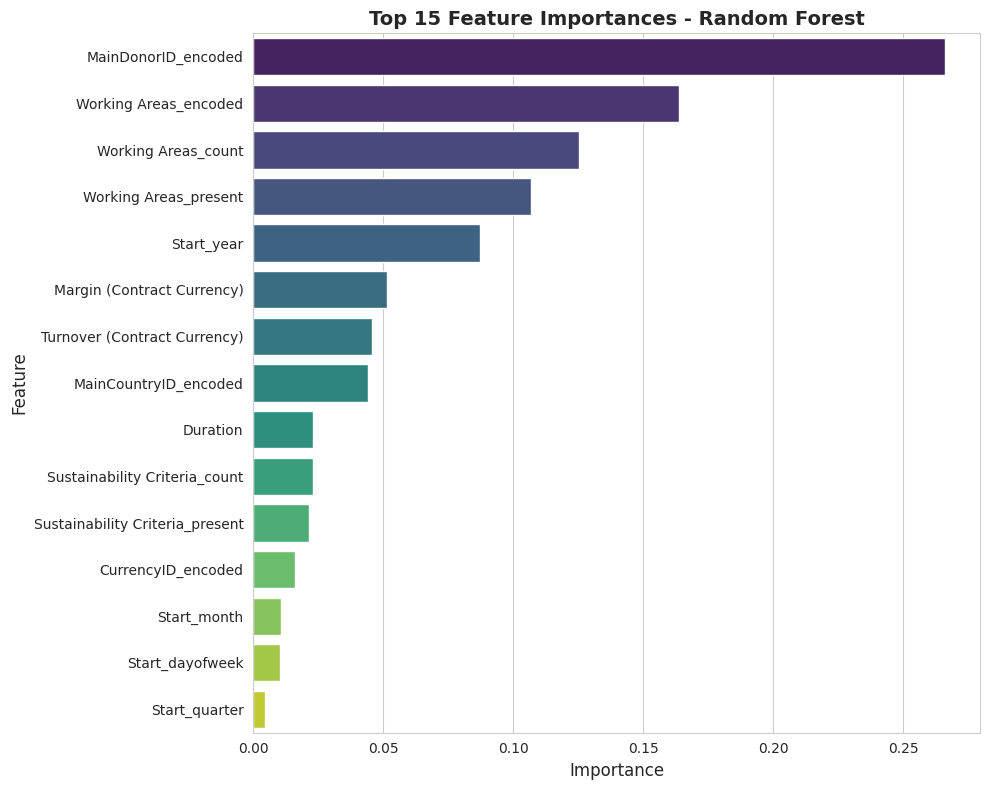


Top 15 Most Important Features:
                        feature  importance
            MainDonorID_encoded    0.266108
          Working Areas_encoded    0.163794
            Working Areas_count    0.125279
          Working Areas_present    0.106761
                     Start_year    0.087345
     Margin (Contract Currency)    0.051467
   Turnover (Contract Currency)    0.045672
          MainCountryID_encoded    0.044253
                       Duration    0.023009
  Sustainability Criteria_count    0.022967
Sustainability Criteria_present    0.021496
             CurrencyID_encoded    0.016145
                    Start_month    0.010775
                Start_dayofweek    0.010100
                  Start_quarter    0.004530


In [69]:
# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    if best_model_name == 'Random Forest':
        importances = rf_model.feature_importances_
    else:
        importances = gb_model.feature_importances_

    feature_imp_df = pd.DataFrame({
        'feature': common_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Top 15 features
    top_features = feature_imp_df.head(15)

    # Visualization
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nTop 15 Most Important Features:")
    print(top_features.to_string(index=False))

elif best_model_name == 'Logistic Regression':
    # For Logistic Regression, use coefficient magnitudes
    coef_df = pd.DataFrame({
        'feature': common_cols,
        'coefficient': baseline_model.coef_[0]
    })
    coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

    top_features = coef_df.head(15)

    # Visualization
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_features, y='feature', x='coefficient', palette='coolwarm')
    plt.title(f'Top 15 Feature Coefficients - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Coefficient', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    print("\nTop 15 Most Important Features (by coefficient magnitude):")
    print(top_features[['feature', 'coefficient']].to_string(index=False))

## PHASE 6: Predictions & Deliverables

### 6.1 Generate Predictions for Test Set

### 6.2 Summary & Key Insights

In [70]:
print("=" * 60)
print("SOLUTION SUMMARY")
print("=" * 60)

print("\n1. PROBLEM FRAMING:")
print("   - Binary classification (Won/Lost)")
print("   - Primary metric: F1-Score")
print("   - Class imbalance: 70.5% Lost, 29.5% Won")

print("\n2. DATA EXPLORATION:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")
print("   - Excluded RD Weight (data leakage)")

print("\n3. FEATURE ENGINEERING:")
print(f"   - Final feature count: {len(common_cols)}")
print("   - Date features extracted (year, month, quarter)")
print("   - Target encoding for high-cardinality IDs")
print("   - One-hot encoding for low-cardinality categoricals")
print("   - Missing value indicators created")
print("   - Text fields processed (count features)")

print("\n4. MODELING:")
print(f"   - Best model: {best_model_name}")
print(f"   - CV F1-Score: {models_comparison.loc[best_model_idx, 'CV_F1_Mean']:.4f}")
print(f"   - Training F1-Score: {models_comparison.loc[best_model_idx, 'Train_F1']:.4f}")

print("\n5. DELIVERABLES:")
print("   - predictions.csv generated")
print("   - Notebook with reproducible code")
print("   - Ready for presentation")

print("\n" + "=" * 60)

SOLUTION SUMMARY

1. PROBLEM FRAMING:
   - Binary classification (Won/Lost)
   - Primary metric: F1-Score
   - Class imbalance: 70.5% Lost, 29.5% Won

2. DATA EXPLORATION:
   - Training samples: 1226
   - Test samples: 164
   - Excluded RD Weight (data leakage)

3. FEATURE ENGINEERING:
   - Final feature count: 16
   - Date features extracted (year, month, quarter)
   - Target encoding for high-cardinality IDs
   - One-hot encoding for low-cardinality categoricals
   - Missing value indicators created
   - Text fields processed (count features)

4. MODELING:
   - Best model: Random Forest
   - CV F1-Score: 0.8019
   - Training F1-Score: 0.8510

5. DELIVERABLES:
   - predictions.csv generated
   - Notebook with reproducible code
   - Ready for presentation



### 6.3 Where AI Assisted

**AI Tools Used:**
- Code generation for feature engineering pipeline (date extraction, target encoding, one-hot encoding)
- Model comparison and evaluation code (cross-validation, metrics calculation)
- Documentation

**Human Decisions Made:**
- **Leakage Detection**: Identified RD Weight as data leakage based on data dictionary description
- **Feature Engineering Strategy**: Chose target encoding for high-cardinality IDs, one-hot for low-cardinality
- **Model Selection Criteria**: Prioritized F1-Score, interpretability, and overfitting prevention
